# This notebook reconstructs alternative buffers to create additional data
Ethnologue data cannot be shared freely due to copyright issues. Therefore you can only view the output of the cells.

# Setup

In [ ]:
import sys, os, time
import matplotlib.pyplot as plt

# Math, data
import numpy as np
import pandas as pd
pd.set_option('display.width', 140)

# GIS packages
os.environ['USE_PYGEOS'] = '0'
from shapely.geometry import Polygon, Point
import pyproj
import georasters as gr
import fiona
import fiona.crs
import geopandas as gp
import geopandas.tools as gpt
gpd = gp
import dask_geopandas

from pyproj import CRS
cea = CRS("ESRI:54034")
wgs84 = CRS("EPSG:4326")

# Plotting
import matplotlib as mpl
import seaborn as sns
# Setup seaborn
sns.set()

# Mapping
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import textwrap

# Various other packages
import isounidecode         # Decode and encode text
import itertools
from functools import reduce

# Paths
proot = '/work/Replication_Dickens_2022/data/'
pathout = proot + 'Ethnologue/'
pathstats = proot + 'stats/'
pathethno = '' # Since the Ethnologed is protected under copy rights we can't upload the dataset.

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def nb_dist(x, y):
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:165: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_faces(triangle):
/users/ozak/micromamb

In [3]:
#%%px --local
def Borders(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.type.isin(["LineString", "MultiLineString"])
        intersections.loc[poly_ix] = intersections[poly_ix]#.buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gpd.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        return gpd.GeoDataFrame(
            [],
            columns=list(set(df1.columns).union(df2.columns)) + ["__idx1", "__idx2"],
            crs=df1.crs,
        )
    
def _overlay_intersection(df1, df2):
    """
    Overlay Intersection operation used in overlay function
    """
    # Spatial Index to create intersections
    idx1, idx2 = df2.sindex.query_bulk(df1.geometry, predicate="intersects", sort=True)
    # Create pairs of geometries in both dataframes to be intersected
    if idx1.size > 0 and idx2.size > 0:
        left = df1.geometry.take(idx1)
        left.reset_index(drop=True, inplace=True)
        right = df2.geometry.take(idx2)
        right.reset_index(drop=True, inplace=True)
        intersections = left.intersection(right)
        poly_ix = intersections.geom_type.isin(["Polygon", "MultiPolygon"])
        intersections.loc[poly_ix] = intersections[poly_ix].buffer(0)

        # only keep actual intersecting geometries
        pairs_intersect = pd.DataFrame({"__idx1": idx1, "__idx2": idx2})
        geom_intersect = intersections

        # merge data for intersecting geometries
        df1 = df1.reset_index(drop=True)
        df2 = df2.reset_index(drop=True)
        dfinter = pairs_intersect.merge(
            df1.drop(df1._geometry_column_name, axis=1),
            left_on="__idx1",
            right_index=True,
        )
        dfinter = dfinter.merge(
            df2.drop(df2._geometry_column_name, axis=1),
            left_on="__idx2",
            right_index=True,
            suffixes=("_1", "_2"),
        )

        return gp.GeoDataFrame(dfinter, geometry=geom_intersect, crs=df1.crs)
    else:
        result = df1.iloc[:0].merge(
            df2.iloc[:0].drop(df2.geometry.name, axis=1),
            left_index=True,
            right_index=True,
            suffixes=("_1", "_2"),
        )
        result["__idx1"] = None
        result["__idx2"] = None
        return result[
            result.columns.drop(df1.geometry.name).tolist() + [df1.geometry.name]
        ]

In [4]:
# Drop repeated pairs
def drop_repeated(df, cols):
    df1 = df[cols].copy()
    df1['reps'] = df1.apply(lambda x: list(set(x[cols].astype(str))), axis=1)
    df1['reps'] = df1.reps.apply(lambda x: '-'.join(x))
    df1 = df1.drop_duplicates('reps')
    df1 = df1.drop('reps', axis=1).reset_index(drop=True)
    return df1

# Using Original Data
## Import original replication files provided with paper
* We import only shapefiles to show construction and difference/similarity. 
* We import only the file for the 50km buffer (i.e., the 100km diameter)

Main original replication data file with all pairwise data based on buffers of 50kms

In [5]:
dfor = pd.read_stata(proot + 'EJ_Dickens_Border_100km.dta')
dfor

/tmp/ipykernel_2943607/3197352363.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dfor = pd.read_stata(pathdickens + 'Data/EJ_Dickens_Border_100km.dta')


,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
1,AAA-NGA-OKE-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Okpe,oke,Nigeria,Niger-Congo,0.628569,...,oke,aaa,oke,GHOTUO,OKPE,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
2,AAB-NGA-JID-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Bu,jid,Nigeria,Niger-Congo,0.833333,...,jid,aab,jid,TESU,BU_NIGERIA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
3,AAB-NGA-RIN-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Nungu,rin,Nigeria,Niger-Congo,NaN,...,rin,aab,rin,TESU,missing,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
4,AAB-NGA-TDV-NGA,Alumu-Tesu,aab,Nigeria,Niger-Congo,Toro,tdv,Nigeria,Niger-Congo,0.532142,...,tdv,aab,tdv,TESU,TORO,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,ZYN-CHN-YUE-CHN,"Zhuang, Yongnan",zyn,China,Tai-Kadai,"Chinese, Yue",yue,China,Sino-Tibetan,0.813015,...,yue,zyn,yue,NINGMING_YONGNAN_ZHUANG,CANTONESE,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15599,ZZJ-CHN-CMN-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,"Chinese, Mandarin",cmn,China,Sino-Tibetan,0.865388,...,cmn,zzj,cmn,LONGZHOU_ZHUANG,KUNMING_MANDARIN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Sino-Tibetan,Chinese",156.0,156.0,Asia
15600,ZZJ-CHN-IUM-CHN,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Iu Mien,ium,China,Hmong-Mien,0.844456,...,ium,zzj,ium,LONGZHOU_ZHUANG,CHIANGRAI_MIEN,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Hmong-Mien,Mienic,Mian-Jin",156.0,156.0,Asia
15601,ZZJ-CHN-TYZ-VNM,"Zhuang, Zuojiang",zzj,China,Tai-Kadai,Tay,tyz,Vietnam,Tai-Kadai,0.528902,...,tyz,zzj,tyz,LONGZHOU_ZHUANG,TAY,"Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central","Tai-Kadai,Kam-Tai,Be-Tai,Tai-Sek,Tai,Central",156.0,704.0,Asia


In [6]:
dfor.loc[dfor.identifier=='SPA-MEX-SPA-GTM']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [7]:
dfor.loc[dfor.identifier=='SPA-GTM-SPA-MEX']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


In [8]:
dfor.loc[dfor.identifier=='AAA-NGA-EMA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region
0,AAA-NGA-EMA-NGA,Ghotuo,aaa,Nigeria,Niger-Congo,Emai-Iuleha-Ora,ema,Nigeria,Niger-Congo,0.459362,...,ema,aaa,ema,GHOTUO,AOMA,"Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...","Niger-Congo,Atlantic-Congo,Volta-Congo,Benue-C...",566.0,566.0,Africa


In [9]:
dfor.loc[dfor.identifier=='EMA-NGA-AAA-NGA']

,identifier,langName_ethno1,langIso1,country1,family1,langName_ethno2,langIso2,country2,family2,lingDist,...,langIso_ethno2,langIso_asjp1,langIso_asjp2,langName_asjp1,langName_asjp2,familyTree1,familyTree2,ccode1,ccode2,region


# New Data
## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
###  Import data

In [21]:
ethno = gp.read_file(pathethno + 'langa.shp')
#ethno = ethno.to_crs(cea)
#ethno['key'] = 0
ethno.head()

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,137000000,137000000.0,"Indo-European, Slavic, East",L,Indo-European,INDO-EUROPEAN,Russian Federation,rus,1,"MULTIPOLYGON (((34.30387 61.85888, 34.34665 61..."
1,ENG-USA,eng-USA,eng-us,eng-US,English,English,ENGLISH,English,Americas,United States,225000000,225000000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,United States,eng,1,"MULTIPOLYGON (((-122.52301 47.78182, -122.5395..."
2,POR-BRA,por-BRA,por-br,por-BR,Portuguese,Portuguese,PORTUGUESE,Portuguese,Americas,Brazil,187000000,187000000.0,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Brazil,por,1,"MULTIPOLYGON (((-52.13058 -31.97901, -52.12447..."
3,ENG-AUS,eng-AUS,eng-au,eng-AS,English,English,ENGLISH,English,Pacific,Australia,15600000,15600000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Australia,eng,1,"MULTIPOLYGON (((142.52003 -10.70436, 142.52347..."
4,ENG-CAN,eng-CAN,eng-ca,eng-CA,English,English,ENGLISH,English,Americas,Canada,19400000,19400000.0,"Indo-European, Germanic, West, English",L,Indo-European,INDO-EUROPEAN,Canada,eng,1,"MULTIPOLYGON (((-74.13254 45.52187, -74.11124 ..."


In [22]:
ethno = ethno.loc[ethno.LMP_POP1>0].reset_index(drop=True)

In [23]:
ethno.shape

(7388, 20)

## Create borders and buffers using full dataset from Ethnologue 17 edition (paper uses version 16)
Find duplicated languages x country. Unlike v16, v17 has a duplicated language

In [34]:
ethno.loc[ethno.duplicated('ID')]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry
4886,ALN-SRB,aln-SRB,aln-rs,aln-RI,Gheg Albanian,"Albanian, Gheg","ALBANIAN, GHEG","Albanian, Gheg",Europe,Serbia,1630000,1630000.0,"Indo-European, Albanian, Gheg",L,Indo-European,INDO-EUROPEAN,Serbia,aln,2,"POLYGON ((21.43371 42.77874, 21.43528 42.81889..."


v17 has invalid geometries

In [35]:
ethno.loc[ethno.is_valid==False, 'geometry'] = ethno.loc[ethno.is_valid==False, 'geometry'].buffer(0)

In [36]:
ethno.loc[ethno.is_valid==False]

,ID,ID_ISO_A3,ID_ISO_A2,ID_FIPS,NAM_LABEL,NAME_PROP,NAME2,NAM_ANSI,CNT,C1,POP,LMP_POP1,G,LMP_CLASS,FAMILYPROP,FAMILY,LMP_C1,LANG_ISO,EGIDS,geometry


## Create all pairs of languages/countries

In [19]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()
print(nb_cpus)

import dask.dataframe as dd
from dask.distributed import Client, progress
client = Client(processes=True,threads_per_worker=1, n_workers=nb_cpus,memory_limit='64G')

# Create a Dask client to utilize multiple cores
client = Client()
client

128


/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40753 instead
  warnings.warn(
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35833 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35833/status,
Dashboard: http://127.0.0.1:35833/status,Workers: 16
Total threads: 128,Total memory: 500.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33985,Workers: 16
Dashboard: http://127.0.0.1:35833/status,Total threads: 128
Started: Just now,Total memory: 500.00 GiB
Comm: tcp://127.0.0.1:35201,Total threads: 8
Dashboard: http://127.0.0.1:36139/status,Memory: 31.25 GiB
Nanny: tcp://127.0.0.1:42835,


In [40]:
ddethno = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno2 = dask_geopandas.from_geopandas(ethno, npartitions=20)
ddethno['geometry'] = ddethno['geometry'].buffer(0.2)

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:6699: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))


In [41]:
pairs = ddethno.sjoin(ddethno2, predicate="intersects").compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return func(*args, **kwargs)
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/utils.py:72: Us

In [42]:
pairs.shape

(75979, 40)

In [43]:
pairs.columns = [c.replace('_left', '_1').replace('_right', '_2') for c in pairs.columns]

In [44]:
pairs.loc[(pairs.ID_1=='MVE-PAK')&(pairs.ID_2=='RWR-IND')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,C1_2,POP_2,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2
423,MVE-PAK,mve-PAK,mve-pk,mve-PK,Marwari,Marwari,MARWARI,Marwari,Asia,Pakistan,...,India,5600000,5600000.0,"Indo-European, Indo-Iranian, Indo-Aryan, Centr...",L,Indo-European,INDO-EUROPEAN,India,rwr,5


In [45]:
pairs = pairs.merge(ethno[['ID', 'geometry']], how='left', left_on='ID_1', right_on='ID', suffixes=['', "_1"])
pairs.head()

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_1
0,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,121000000.0,Japonic,L,Japonic,JAPONIC,Japan,jpn,1,RUS-RUS,"MULTIPOLYGON (((179.82201 66.03618, 179.94593 ..."
1,JPN-JPN,jpn-JPN,jpn-jp,jpn-JA,Japanese,Japanese,JAPANESE,Japanese,Asia,Japan,...,121000000.0,Japonic,L,Japonic,JAPONIC,Japan,jpn,1,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,rus-RUS,rus-ru,rus-RS,Russian,Russian,RUSSIAN,Russian,Europe,Russian Federation,...,840000000.0,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,RUS-RUS,"MULTIPOLYGON (((179.82201 66.03618, 179.94593 ..."
3,CMN-CHN,cmn-CHN,cmn-cn,cmn-CH,Mandarin Chinese,"Chinese, Mandarin","CHINESE, MANDARIN","Chinese, Mandarin",Asia,China,...,840000000.0,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ..."
4,KHK-MNG,khk-MNG,khk-mn,khk-MG,Halh Mongolian,"Mongolian, Halh","MONGOLIAN, HALH","Mongolian, Halh",Asia,Mongolia,...,840000000.0,"Sino-Tibetan, Chinese",L,Sino-Tibetan,SINO-TIBETAN,China,cmn,1,KHK-MNG,"POLYGON ((99.69989 51.90961, 99.72758 51.90153..."


In [46]:
pairs['geometry'] = pairs['geometry_1'].values
pairs[['ID_1', 'ID', 'geometry', 'geometry_1']].head()

,ID_1,ID,geometry,geometry_1
0,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...","MULTIPOLYGON (((179.82201 66.03618, 179.94593 ..."
1,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((134.24844 34.70230, 134.25470 ...","MULTIPOLYGON (((134.24844 34.70230, 134.25470 ..."
2,RUS-RUS,RUS-RUS,"MULTIPOLYGON (((179.82201 66.03618, 179.94593 ...","MULTIPOLYGON (((179.82201 66.03618, 179.94593 ..."
3,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((116.32026 40.72407, 116.42109 ...","MULTIPOLYGON (((116.32026 40.72407, 116.42109 ..."
4,KHK-MNG,KHK-MNG,"POLYGON ((99.69989 51.90961, 99.72758 51.90153...","POLYGON ((99.69989 51.90961, 99.72758 51.90153..."


In [47]:
pairs = pairs.drop(columns=['ID', 'geometry_1'])

In [48]:
pairs = pairs.to_crs(cea)

In [49]:
pairs = pairs.merge(ethno[['ID', 'geometry']].to_crs(cea), how='left', left_on='ID_2', right_on='ID', suffixes=['_1', "_2"])
pairs[['ID_1', 'ID_2', 'ID', 'geometry_1', 'geometry_2']].head()

,ID_1,ID_2,ID,geometry_1,geometry_2
0,RUS-RUS,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((20017694.474 5811022.138, 2003...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
1,JPN-JPN,JPN-JPN,JPN-JPN,"MULTIPOLYGON (((14944468.315 3612072.777, 1494...","MULTIPOLYGON (((14944468.315 3612072.777, 1494..."
2,RUS-RUS,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((20017694.474 5811022.138, 2003...","MULTIPOLYGON (((12948712.669 4141219.582, 1295..."
3,CMN-CHN,CMN-CHN,CMN-CHN,"MULTIPOLYGON (((12948712.669 4141219.582, 1295...","MULTIPOLYGON (((12948712.669 4141219.582, 1295..."
4,KHK-MNG,CMN-CHN,CMN-CHN,"POLYGON ((11098540.987 5000070.539, 11101623.8...","MULTIPOLYGON (((12948712.669 4141219.582, 1295..."


In [50]:
%time
pairs = pairs.loc[pairs['ID_1']!=pairs['ID_2']].reset_index(drop=True)
pairs.shape

CPU times: user 13 µs, sys: 0 ns, total: 13 µs
Wall time: 25.3 µs


(68607, 42)

In [51]:
pairs[['ID_1', 'ID_2', 'NAME2_1', 'NAME2_2']].head()

,ID_1,ID_2,NAME2_1,NAME2_2
0,RUS-RUS,JPN-JPN,RUSSIAN,JAPANESE
1,RUS-RUS,CMN-CHN,RUSSIAN,"CHINESE, MANDARIN"
2,KHK-MNG,CMN-CHN,"MONGOLIAN, HALH","CHINESE, MANDARIN"
3,MVF-CHN,CMN-CHN,"MONGOLIAN, PERIPHERAL","CHINESE, MANDARIN"
4,KHG-CHN,CMN-CHN,"TIBETAN, KHAMS","CHINESE, MANDARIN"


We have dropped all same pair language/countries, now let's drop all same langauge pairs that are in differenct countries (e.g., SPA-MEX and SPA-GTM). Special case MVE-PAK and RWR-IND are the same language (NAME2) even though they have different ISO codes. It's not clear there is a reason for different ISO code, so we also drop them

(see https://wikitongues.org/languages/mve/, https://wikitongues.org/languages/rwr/, https://www.ethnologue.com/language/rwr/, https://www.ethnologue.com/language/mve/)

**This differs from Dickens, he seems to keep these**

In [52]:
pairs.loc[(pairs['ID_1']=='SPA-MEX')& (pairs['ID_2']=='SPA-GTM')]

,ID_1,ID_ISO_A3_1,ID_ISO_A2_1,ID_FIPS_1,NAM_LABEL_1,NAME_PROP_1,NAME2_1,NAM_ANSI_1,CNT_1,C1_1,...,LMP_POP1_2,G_2,LMP_CLASS_2,FAMILYPROP_2,FAMILY_2,LMP_C1_2,LANG_ISO_2,EGIDS_2,ID,geometry_2
531,SPA-MEX,spa-MEX,spa-mx,spa-MX,Spanish,Spanish,SPANISH,Spanish,Americas,Mexico,...,9000000.0,"Indo-European, Italic, Romance, Italo-Western,...",L,Indo-European,INDO-EUROPEAN,Guatemala,spa,1,SPA-GTM,"MULTIPOLYGON (((-9851665.330 1735317.342, -984..."


In [53]:
pairs = pairs.loc[pairs['NAME2_1']!=pairs['NAME2_2']].reset_index(drop=True)
#pairs = pairs.loc[(pairs['ID_1']!='ALN-SRB') & (pairs['ID_2']!='ALN-SRB')].reset_index(drop=True)
pairs.shape

(67235, 42)

In [54]:
%time
non_repeated_pairs = drop_repeated(pairs, ['ID_1', 'ID_2'])

CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 25 µs


In [55]:
non_repeated_pairs

,ID_1,ID_2
0,RUS-RUS,JPN-JPN
1,RUS-RUS,CMN-CHN
2,KHK-MNG,CMN-CHN
3,MVF-CHN,CMN-CHN
4,KHG-CHN,CMN-CHN
...,...,...
36628,AFN-NGA,NKX-NGA
36629,NKX-NGA,AFN-NGA
36630,BHE-PAK,AEQ-PAK
36631,AEQ-PAK,BHE-PAK


In [56]:
pairs2 = pairs.loc[(pairs.ID_1=='ENG-USA')&(pairs.ID_2=='SPA-MEX')].reset_index()
pairs2[['ID_1', 'ID_2', 'geometry_1', 'geometry_2']]
pairs2['buffer_2'] = pairs2.apply(lambda x: x.geometry_1.buffer(50000).intersection(x.geometry_2), axis=1)
pairs2['buffer_1'] = pairs2.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1), axis=1)

<AxesSubplot:>

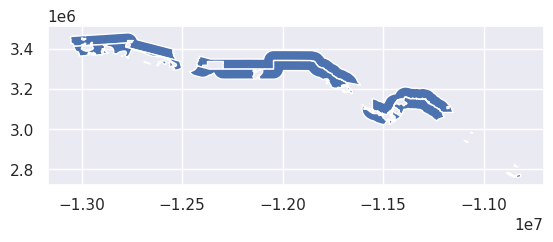

In [57]:
pairs3 = gp.GeoDataFrame(pd.concat([pairs2[['ID_1', 'ID_2', 'buffer_1']].rename(columns={'buffer_1':'geometry'}), pairs2[['ID_1', 'ID_2', 'buffer_2']].rename(columns={'buffer_2':'geometry'})]), 
                 columns=['ID_1', 'ID_2', 'geometry'],
                 crs=cea, geometry='geometry')
pairs3.plot()

# New Data - Buffers

Load the pairs from v17 that are actually linked to Dickens

In [58]:
buffersv17 = gp.read_file(pathout + 'Dickens_ethnologue_bordersv17_cyl.json', driver="GeoJSON")

In [59]:
merged_iden = buffersv17[['identifier']].copy()
merged_iden

,identifier
0,KHK-MNG-CMN-CHN
1,KHG-CHN-CMN-CHN
2,ADX-CHN-CMN-CHN
3,XAL-CHN-CMN-CHN
4,KAZ-CHN-CMN-CHN
...,...
13820,MUC-CMR-BOE-CMR
13821,TQL-VUT-URR-VUT
13822,BDX-IDN-TOY-IDN
13823,TUC-PNG-BBV-PNG


In [60]:
pairs.shape

(67235, 42)

In [62]:
pairs['identifier'] = pairs['ID_1'] + '-' + pairs['ID_2']

In [66]:
subpairs = pairs.merge(merged_iden)

In [ ]:
prob = []
for i in range(subpairs.shape[0]):
    try:
        

We compute buffers and stats only for merged pairs (full sample has issues due to invalid geometries)

In [79]:
def buffer_intersect(row):
    try:
        out1 = row.geometry_1.buffer(50000).buffer(0).intersection(row.geometry_2.buffer(0))
    except:
        out1 = row.identifier
    try:
        out2 = row.geometry_2.buffer(50000).buffer(0).intersection(row.geometry_1.buffer(0))
    except:
        out2 = row.ID_1
    return [out1, out2]

In [84]:
pairs.iloc[10:20].geometry_1.apply(buffer_intersect, axis=1)

10    [MULTIPOLYGON (((14119848.920480538 4676336.04...
11    [MULTIPOLYGON (((12443472.934277562 2804769.43...
12    [MULTIPOLYGON (((12329482.532873858 2646004.25...
13    [MULTIPOLYGON (((13037692.599587351 3233670.24...
14    [POLYGON ((13789081.953173118 4066524.71683114...
15    [MULTIPOLYGON (((11973452.02102267 2378275.360...
16    [MULTIPOLYGON (((10890243.536652457 2700251.14...
17    [MULTIPOLYGON (((12133897.050230002 2921028.93...
18    [MULTIPOLYGON (((11010701.566853492 2720272.47...
19    [MULTIPOLYGON (((11862577.628919119 2938906.11...
dtype: object

In [88]:
ddpairs = dask_geopandas.from_geopandas(pairs, npartitions=20)

In [89]:
ddpairs['geometry_1'] = ddpairs['geometry_1'].apply(lambda x: x.buffer(0), meta=('geometry_1', 'geometry'))
ddpairs['geometry_2'] = ddpairs['geometry_2'].apply(lambda x: x.buffer(0), meta=('geometry_2', 'geometry'))
ddpairs['buffer_2'] = ddpairs.apply(lambda x: x.geometry_1.buffer(0).buffer(50000).intersection(x.geometry_2), axis=1, meta=(None, 'geometry'))
ddpairs['buffer_1'] = ddpairs.apply(lambda x: x.geometry_2.buffer(50000).intersection(x.geometry_1.buffer(0)), axis=1, meta=(None, 'geometry'))
buffers = ddpairs.compute()

/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:4245: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('geometry_1', 'object'))

  warnings.warn(meta_warning(meta))
/users/ozak/micromamba/envs/GeoPython39env/lib/python3.9/site-packages/dask/dataframe/core.py:4245: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  A

In [90]:
buffers[['ID_1', 'ID_2', 'buffer_1', 'buffer_2']]

,ID_1,ID_2,buffer_1,buffer_2
0,RUS-RUS,JPN-JPN,MULTIPOLYGON (((15798275.997472135 4580792.072...,MULTIPOLYGON (((15832575.743105846 4511966.449...
1,RUS-RUS,CMN-CHN,MULTIPOLYGON (((13755709.0257285 5109341.19719...,MULTIPOLYGON (((14776502.06855399 4546876.8010...
2,KHK-MNG,CMN-CHN,POLYGON ((10715363.408863308 4354297.163114779...,POLYGON ((10842561.151102789 4259957.376695122...
3,MVF-CHN,CMN-CHN,MULTIPOLYGON (((10889648.61446669 4301787.6197...,MULTIPOLYGON (((10787585.679967364 4277137.332...
4,KHG-CHN,CMN-CHN,POLYGON ((11314343.319314852 3114405.916329438...,"POLYGON ((11388374.26249197 3261457.373360153,..."
...,...,...,...,...
67230,NKX-NGA,AFN-NGA,"POLYGON ((831223.5859426255 502037.7397955065,...","POLYGON ((830847.1449290809 502057.212584235, ..."
67231,BHE-PAK,AEQ-PAK,"POLYGON ((7734927.60600051 2707613.9355851137,...",POLYGON ((7741831.356025469 2696790.6808052002...
67232,AEQ-PAK,BHE-PAK,POLYGON ((7741831.356025469 2696790.6808052002...,"POLYGON ((7734927.60600051 2707613.9355851137,..."
67233,XNB-TWN,SXR-TWN,POLYGON ((13457178.135271138 2510337.991613844...,POLYGON ((13437662.826614013 2504109.271347125...


In [91]:
buffers['identifier'] = buffers['ID_1'] + '-' + buffers['ID_2']

In [92]:
buffers1_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_1']], crs=cea, geometry='buffer_1')
buffers1_geo.head()

,identifier,ID_1,ID_2,buffer_1
0,RUS-RUS-JPN-JPN,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((15798275.997 4580792.072, 1580..."
1,RUS-RUS-CMN-CHN,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((13755709.026 5109341.197, 1375..."
2,KHK-MNG-CMN-CHN,KHK-MNG,CMN-CHN,"POLYGON ((10715363.409 4354297.163, 10720027.3..."
3,MVF-CHN-CMN-CHN,MVF-CHN,CMN-CHN,"MULTIPOLYGON (((10889648.614 4301787.620, 1088..."
4,KHG-CHN-CMN-CHN,KHG-CHN,CMN-CHN,"POLYGON ((11314343.319 3114405.916, 11313568.8..."


In [93]:
buffers2_geo = gp.GeoDataFrame(buffers[['identifier', 'ID_1', 'ID_2', 'buffer_2']], crs=cea, geometry='buffer_2')
buffers2_geo.head()

,identifier,ID_1,ID_2,buffer_2
0,RUS-RUS-JPN-JPN,RUS-RUS,JPN-JPN,"MULTIPOLYGON (((15832575.743 4511966.449, 1582..."
1,RUS-RUS-CMN-CHN,RUS-RUS,CMN-CHN,"MULTIPOLYGON (((14776502.069 4546876.801, 1477..."
2,KHK-MNG-CMN-CHN,KHK-MNG,CMN-CHN,"POLYGON ((10842561.151 4259957.377, 10837535.4..."
3,MVF-CHN-CMN-CHN,MVF-CHN,CMN-CHN,"MULTIPOLYGON (((10787585.680 4277137.333, 1078..."
4,KHG-CHN-CMN-CHN,KHG-CHN,CMN-CHN,"POLYGON ((11388374.262 3261457.373, 11391188.7..."


In [94]:
buffers1_geo.to_file(pathout + 'ethnologue_buffers_alt1_v17.json', driver="GeoJSON")
buffers2_geo.to_file(pathout + 'ethnologue_buffers_alt2_v17.json', driver="GeoJSON")

2023-06-10 19:31:51,434 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 22.87 GiB -- Worker memory limit: 31.25 GiB
2023-06-10 19:31:52,796 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 22.59 GiB -- Worker memory limit: 31.25 GiB
2023-06-10 19:32:01,455 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. 

No need to recreate overlap etc, we can use what we created in [Replication-Construct-Buffers-Touch-v17.ipynb](/work/Replication_Dickens_2022/Replication-Construct-Buffers-Touch-v17.ipynb)

# New Data - Spatial Stats for New Buffers

In [5]:
buffers1_geo = gp.read_file(pathout + 'ethnologue_buffers_alt1_v17.json', driver="GeoJSON")
buffers2_geo = gp.read_file(pathout + 'ethnologue_buffers_alt2_v17.json', driver="GeoJSON")

Work with CSI data to compute spatial statistics

In [6]:
CSI = os.listdir(proot + 'CSI')

In [7]:
CSI.remove('ReadMe.txt')
CSI.sort()
CSI

['dif2AverageCalories.tif',
 'dif2AverageCalories0.tif',
 'dif2AverageCaloriesNo0.tif',
 'dif2OptCalories.tif',
 'dif2OptCalories0.tif',
 'dif2OptCaloriesNo0.tif',
 'difAverageCalories.tif',
 'difAverageCalories0.tif',
 'difAverageCaloriesNo0.tif',
 'difOptCalories.tif',
 'difOptCalories0.tif',
 'difOptCaloriesNo0.tif',
 'post1500AverageCalories.tif',
 'post1500AverageCalories0.tif',
 'post1500AverageCaloriesNo0.tif',
 'post1500OptCalories.tif',
 'post1500OptCalories0.tif',
 'post1500OptCaloriesNo0.tif',
 'pre15002AverageCalories.tif',
 'pre15002AverageCalories0.tif',
 'pre15002AverageCaloriesNo0.tif',
 'pre15002OptCalories.tif',
 'pre15002OptCalories0.tif',
 'pre15002OptCaloriesNo0.tif',
 'pre1500AverageCalories.tif',
 'pre1500AverageCalories0.tif',
 'pre1500AverageCaloriesNo0.tif',
 'pre1500OptCalories.tif',
 'pre1500OptCalories0.tif',
 'pre1500OptCaloriesNo0.tif']

In [8]:
buffers1_geo = buffers1_geo.to_crs(wgs84)
buffers2_geo = buffers2_geo.to_crs(wgs84)

In [11]:
%%time
for r in CSI:
    print(r.replace('.tif', ''))
    # Import raster
    csi = gr.from_file(proot + '/CSI/' + r)
    # Compute stats for first section of buffer
    out= csi.stats(buffers1_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta', version=117, write_index=False)    
    # Compute stats for second section of buffer    
    out= csi.stats(buffers2_geo, add_stats={'median':np.ma.median, 'std':np.ma.std, 'max':np.ma.max, 'min':np.ma.min}, raster_out=False)
    print(out.columns)
    for c in out.columns[3:]:
        out[c] = out[c].astype(float)
    out.columns = ['identifier', 'ID_1', 'ID_2'] + [r.replace('.tif', '') + c for c in out.columns[3:]]
    out.to_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt2.dta', version=117, write_index=False)

dif2AverageCalories
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2AverageCalories0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2AverageCaloriesNo0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2OptCalories
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
dif2OptCalories0
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean', 'min'], dtype='object')
Index(['identifier', 'ID_1', 'ID_2', 'max', 'median', 'std', 'mean

In [40]:
%%time
out = []
for r in CSI:
    print(r.replace('.tif', ''))
    out1 = pd.read_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt.dta')   
    out1 = out1.set_index(['identifier', 'ID_1', 'ID_2'])
    out2 = pd.read_stata(pathstats + 'Dickens_ethnologue_v17_' + r.replace('.tif', '') + '_alt2.dta')
    out2 = out2.set_index(['identifier', 'ID_1', 'ID_2'])
    out.append((out1[out1.columns] - out2[out1.columns]).abs())

dif2AverageCalories
dif2AverageCalories0
dif2AverageCaloriesNo0
dif2OptCalories
dif2OptCalories0
dif2OptCaloriesNo0
difAverageCalories
difAverageCalories0
difAverageCaloriesNo0
difOptCalories
difOptCalories0
difOptCaloriesNo0
post1500AverageCalories
post1500AverageCalories0
post1500AverageCaloriesNo0
post1500OptCalories
post1500OptCalories0
post1500OptCaloriesNo0
pre15002AverageCalories
pre15002AverageCalories0
pre15002AverageCaloriesNo0
pre15002OptCalories
pre15002OptCalories0
pre15002OptCaloriesNo0
pre1500AverageCalories
pre1500AverageCalories0
pre1500AverageCaloriesNo0
pre1500OptCalories
pre1500OptCalories0
pre1500OptCaloriesNo0
CPU times: user 9.35 s, sys: 119 ms, total: 9.47 s
Wall time: 9.48 s


In [41]:
out = pd.concat(out, axis=1)

In [42]:
out.to_stata(proot + 'Dickens_AltBuf_v17_absdif.dta', version=117)